<a href="https://colab.research.google.com/github/Yoon-juhan/img2img-style-transfer/blob/main/Stable_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 필요한 라이브러리 설치
# !pip install diffusers transformers accelerate

In [ ]:
# 라이브러리 불러오기
from transformers import BlipProcessor, BlipForConditionalGeneration
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline
from PIL import Image
import matplotlib.pyplot as plt
import torch
from google.colab import files, drive
from huggingface_hub import login

In [ ]:
# 디바이스 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Hugging Face 로그인
login()

In [ ]:
# BLIP 모델 로드 (이미지 캡셔닝)
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

In [ ]:
# 이미지 업로드 및 설명 생성
uploaded = files.upload()

for file_name in uploaded.keys():
    image = Image.open(file_name).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    out = model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)

    print(f"\n이미지 파일: {file_name}")
    print(f"생성된 프롬프트: {caption}")

    # 첫 번째 이미지만 사용
    init_image = image.resize((512, 512))
    break

Saving test.jpg to test (1).jpg

이미지 파일: test (1).jpg
생성된 프롬프트: a woman with long black hair and a white shirt


In [ ]:
# Stable Diffusion 모델 로드
# pipe = StableDiffusionPipeline.from_pretrained(
#     "ckpt/anything-v4.5",  # 로컬 경로 또는 Hugging Face 모델 경로
#     torch_dtype=torch.float16
# ).to("cuda")

# pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
#     "nitrosocke/Ghibli-Diffusion",  # 로컬 경로 또는 Hugging Face 모델 경로
#     torch_dtype=torch.float32  # cpu에서는 32
# ).to("cpu")

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "nitrosocke/Ghibli-Diffusion",  # 로컬 경로 또는 Hugging Face 모델 경로
    torch_dtype=torch.float16  # cpu에서는 32
).to("cuda")

# https://huggingface.co/nitrosocke/Ghibli-Diffusion

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# Google Drive 마운트 및 LoRA 로드
drive.mount("/content/drive")
lora_path = "/content/drive/MyDrive/LoRA/ghibli_style_offset.safetensors"
pipe.load_lora_weights(lora_path, weight=1.0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Safety Checker 비활성화
def dummy(images, **kwargs):
    return images, [False] * len(images)
pipe.safety_checker = dummy

In [ ]:
# 프롬프트 구성 및 이미지 생성
prompt = f"<lora:ghibli_style_offset:1> ghibli style, {caption}, GHIBLI STYLE, studio ghibli, anime style, soft lighting, vivid colors, highly detailed, whimsical background, cinematic composition, fantasy atmosphere"

output = pipe(
    prompt=prompt,
    image=init_image,
    strength=0.4,
    guidance_scale=8
).images[0]

  0%|          | 0/15 [00:00<?, ?it/s]

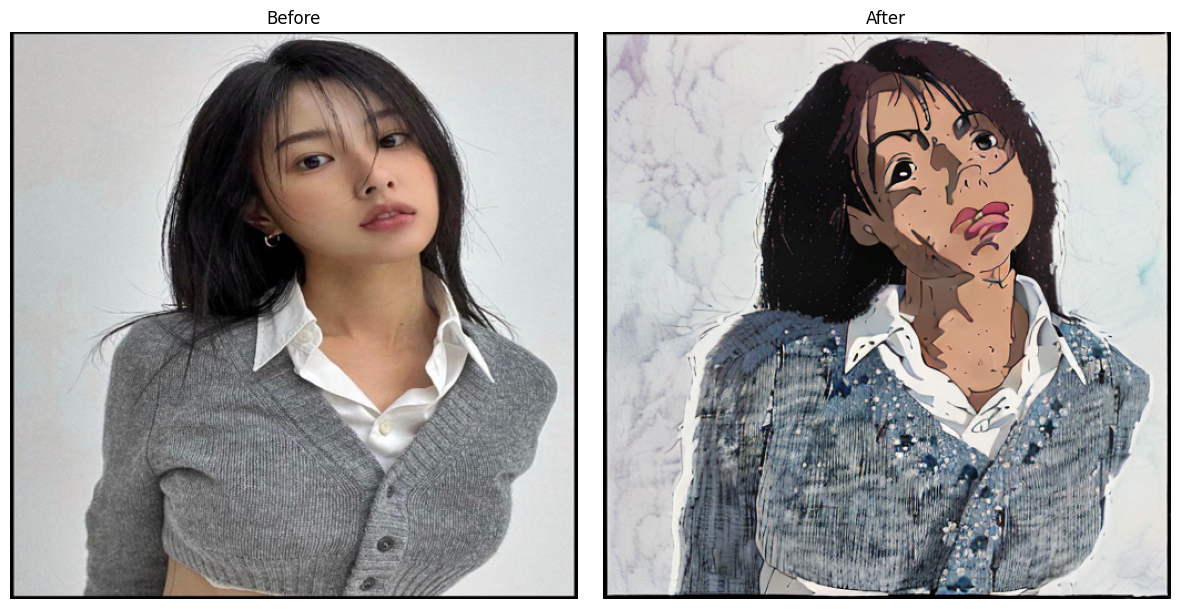

In [ ]:
# 출력 이미지 저장
output.save("ghibli_output.png")

# 전후 이미지 출력
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(init_image)
axes[0].set_title("Before")
axes[0].axis("off")

axes[1].imshow(output)
axes[1].set_title("After")
axes[1].axis("off")

plt.tight_layout()
plt.show()